In [1]:
!pip install -U efficientnet &> /dev/null
!pip install -U keras_retinanet &> /dev/null

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'1.+TABLE+OF+CONTENTS+(Thesis)+-+SAMPLE+1.docx'   Models
'2.+TABLE+OF+CONTENT+(Thesis)+-+SAMPLE+2.docx'	 'My Drive'
'Colab Notebooks'				  NKFoodie.zip
 CXP_EfficientNetB3.h5				  NK_Interim_Report.docx
 Final_Thesis_Sample.pdf			  Public
 images						  yolov3
 LPM						  yolov4


In [4]:
!cp /mydrive/Public/RSNA_Pneumonia_Test.zip /content/

In [5]:
!unzip /content/RSNA_Pneumonia_Test -d /content/ &> /dev/null

In [9]:
!cp /mydrive/Public/RSNA_Pneumonia_75M_25F_LSM.h5 /content/
!cp /mydrive/Public/lsm.h5 /content/

In [7]:
!cp /mydrive/Public/Subsets.zip /content/

In [8]:
!unzip /content/Subsets -d /content/ &> /dev/null

In [10]:
# Dataset paths and classes
parent="RSNA_Pneumonia_Test"
test_path =parent+"/Test"

In [11]:
#Helper
import random
import numpy as np
import pandas as pd
import os

# Modeling
import tensorflow as tf
import efficientnet.keras as efn 
from keras import Model
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,GlobalAveragePooling2D,GlobalMaxPooling2D,Flatten,Conv2D, MaxPooling2D,Activation,Input
from keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

#RetinaNet Imports
from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image

#Image Processing
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import albumentations as A
from PIL import Image
import keras_preprocessing

#Metrics
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,f1_score
from sklearn import metrics

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

#Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
def detect_lungs(xray_file,lsm,threshold=1):
    im = np.array(cv2.imread(xray_file))
    #if there's a PNG it will have alpha channel
    im = im[:,:,:3]
    
    imp = preprocess_image(im)
    imp, scale = resize_image(im)
    
    boxes, scores, labels = lsm.predict_on_batch(np.expand_dims(imp, axis=0))
    
    # standardize box coordinates
    boxes /= scale

    # loop through each prediction for the input image
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < threshold:
            break
            
    box=box.astype(np.int32)
    x0 = box[0]
    y0 = box[1]
    width = box[2]
    height = box[3]
    
    imlungs= im[y0:height , x0:width]
    
    img = Image.fromarray(imlungs)
    img.save(xray_file)

In [13]:
def print_classification_report(y_true,y_pred):
    cf_matrix=confusion_matrix(np.array(y_true), np.array(y_pred))
    sns.heatmap(cf_matrix, annot=True,cmap='Blues',fmt='g')
    print('Classification Report')
    target_names = ['Not Pneumonia', 'Pneumonia']
    print(classification_report(np.array(y_true), y_pred, target_names=target_names,))

In [14]:
def plot_roc(y_true,y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y_true),np.array(y_pred))
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [16]:
def show_xray(xray_path):
    if isinstance(xray_path, str):
        xray=cv2.imread(xray_path)
        plt.imshow(xray)
    else:
        plt.imshow(xray_path)

In [17]:
lsm = models.load_model('lsm.h5', backbone_name='resnet50')
lsm = models.convert_model(lsm)

In [18]:
dir_list=['RSNA_Pneumonia_Test/Test/Pneumonia','RSNA_Pneumonia_Test/Test/Not Pneumonia']
test_df=pd.read_csv('/content/Subsets/RSNA_Pneumonia_75M_25F.csv')
for directory in dir_list:
  for xray in os.listdir(directory):
    xray_file=directory+"/"+xray
    gender=test_df[test_df['xray']==xray]['sex'].values[0]
    #if gender=='F':
    detect_lungs(xray_file,lsm)

In [19]:
!nvidia-smi

Sun May  9 12:46:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    39W / 250W |   5195MiB / 16280MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
test_model=tf.keras.models.load_model('/content/RSNA_Pneumonia_75M_25F_LSM.h5')

In [21]:
test_dir_path=[test_path+"/Pneumonia",test_path+"/Not Pneumonia"]

In [22]:
rsna_df=pd.read_csv('/content/Subsets/RSNA_Pneumonia_75M_25F.csv')

In [23]:
rsna_df['label_description']=rsna_df['label'].map({0:'Not Pneumonia',1:'Pneumonia'})

In [24]:
data=[]
for directory in test_dir_path:
    for file in os.listdir(directory):
        data.append(file.replace(".png",".dcm"))

In [25]:
rsna_test_df=rsna_df[rsna_df['dicom'].isin(data)]

In [26]:
rsna_test_df['xray_file']=test_path+"/"+rsna_test_df['label_description']+"/"+rsna_test_df['xray']
rsna_test_df['label_description'].value_counts()

Not Pneumonia    300
Pneumonia        300
Name: label_description, dtype: int64

In [27]:
#Constants
IMG_SIZE=300
test_gen=ImageDataGenerator(rescale=1./255.)
test_generator=test_gen.flow_from_dataframe(rsna_test_df
                                           ,x_col='xray_file'
                                           ,y_col='label'
                                           ,target_size=(IMG_SIZE,IMG_SIZE) 
                                           ,class_mode=None
                                           ,shuffle=False
                                           )

Found 600 validated image filenames.


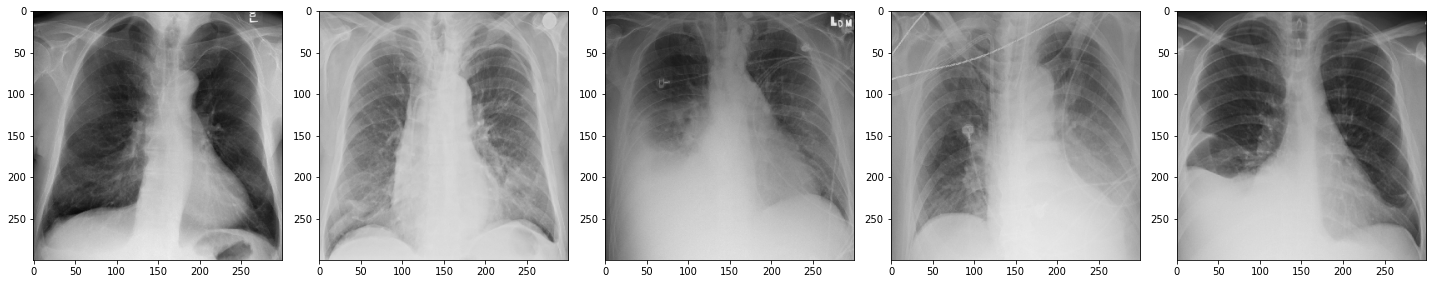

In [28]:
augmented_images = [test_generator[0][i] for i in range(5)]
plotImages(augmented_images)

In [29]:
%%time
y_pred = test_model.predict(test_generator)

CPU times: user 16.1 s, sys: 614 ms, total: 16.7 s
Wall time: 15.5 s


In [30]:
predictions = np.argmax(y_pred, axis=1)
prediction_probs=[class_prob[1] for class_prob in y_pred]
rsna_test_df['ENetB3']=predictions
rsna_test_df['ENetB3_probs']=prediction_probs
rsna_test_df['ENetB3_description']=rsna_test_df['ENetB3'].map({0:'Not Pneumonia',1:'Pneumonia'})

In [31]:
f1_score(rsna_test_df['label'].values,rsna_test_df['ENetB3'].values,average='micro')

0.7816666666666666

Classification Report
               precision    recall  f1-score   support

Not Pneumonia       0.84      0.69      0.76       300
    Pneumonia       0.74      0.87      0.80       300

     accuracy                           0.78       600
    macro avg       0.79      0.78      0.78       600
 weighted avg       0.79      0.78      0.78       600



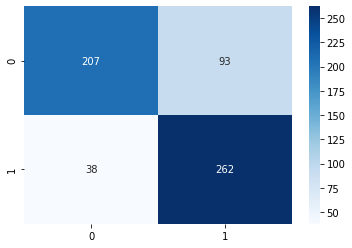

In [32]:
print_classification_report(rsna_test_df['label'].values,rsna_test_df['ENetB3'].values)

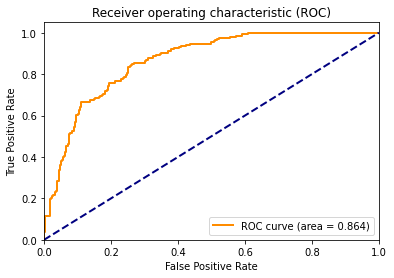

In [33]:
plot_roc(rsna_test_df['label'].values,rsna_test_df['ENetB3_probs'].values)

In [34]:
f1_score(rsna_test_df[rsna_test_df['sex']=='F']['label'].values,rsna_test_df[rsna_test_df['sex']=='F']['ENetB3'].values,average='micro')

0.7866666666666666

Classification Report
               precision    recall  f1-score   support

Not Pneumonia       0.85      0.70      0.77       150
    Pneumonia       0.74      0.87      0.80       150

     accuracy                           0.79       300
    macro avg       0.80      0.79      0.79       300
 weighted avg       0.80      0.79      0.79       300



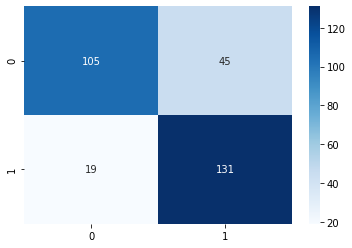

In [35]:
print_classification_report(rsna_test_df[rsna_test_df['sex']=='F']['label'].values,rsna_test_df[rsna_test_df['sex']=='F']['ENetB3'].values)

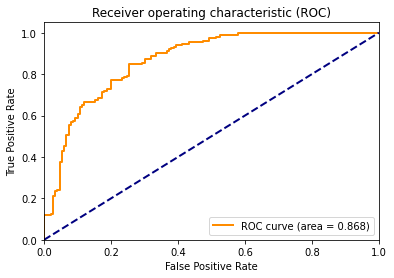

In [36]:
plot_roc(rsna_test_df[rsna_test_df['sex']=='F']['label'].values,rsna_test_df[rsna_test_df['sex']=='F']['ENetB3_probs'].values)

In [37]:
f1_score(rsna_test_df[rsna_test_df['sex']=='M']['label'].values,rsna_test_df[rsna_test_df['sex']=='M']['ENetB3'].values,average='micro')

0.7766666666666666

Classification Report
               precision    recall  f1-score   support

Not Pneumonia       0.84      0.68      0.75       150
    Pneumonia       0.73      0.87      0.80       150

     accuracy                           0.78       300
    macro avg       0.79      0.78      0.77       300
 weighted avg       0.79      0.78      0.77       300



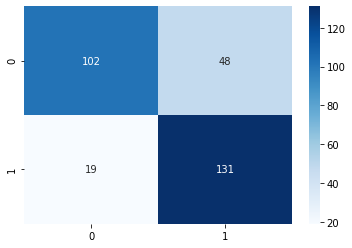

In [38]:
print_classification_report(rsna_test_df[rsna_test_df['sex']=='M']['label'].values,rsna_test_df[rsna_test_df['sex']=='M']['ENetB3'].values)

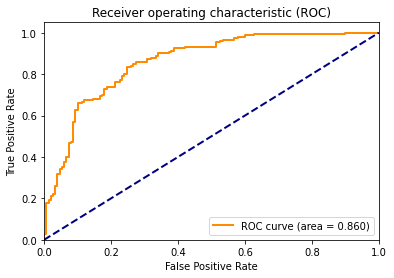

In [39]:
plot_roc(rsna_test_df[rsna_test_df['sex']=='M']['label'].values,rsna_test_df[rsna_test_df['sex']=='M']['ENetB3_probs'].values)

In [40]:
detailed_truth=pd.read_csv('Subsets/stage_2_detailed_class_info.csv')
detailed_truth.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [41]:
pathology="Not Pneumonia"
nofinding_errors=rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)]

In [42]:
def get_detailed_truth(df):
    return detailed_truth[detailed_truth['patientId']==df['patient_id']]['class'].values[0]

In [43]:
nofinding_errors['detailed_truth']=nofinding_errors.apply(get_detailed_truth,axis=1)
nofinding_errors[['label_description','detailed_truth','ENetB3_description']].groupby(['detailed_truth']).count()

,label_description,ENetB3_description
detailed_truth,,
No Lung Opacity / Not Normal,86,86
Normal,7,7


In [44]:
pathology="Pneumonia"
pneumonia_errors=rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)]

In [45]:
pneumonia_errors['detailed_truth']=pneumonia_errors.apply(get_detailed_truth,axis=1)
pneumonia_errors[['label_description','detailed_truth','ENetB3_description']].groupby(['detailed_truth']).count()

,label_description,ENetB3_description
detailed_truth,,
Lung Opacity,38,38


In [46]:
pathology="Not Pneumonia"
rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)][['xray','sex','label_description','ENetB3_description','ENetB3_probs']].head(15)

,xray,sex,label_description,ENetB3_description,ENetB3_probs
3417,d1cf6d7d-0e8f-4c94-8ce7-739388aed78a.png,M,Not Pneumonia,Pneumonia,0.707467
3419,e0fa42ad-0d4a-4827-bc8a-812825aab227.png,M,Not Pneumonia,Pneumonia,0.685207
3420,55e8ab4e-b6c3-4424-bae7-3b17849a1141.png,M,Not Pneumonia,Pneumonia,0.862091
3423,695b6d1e-f8d7-426a-8abe-aba77943ab71.png,M,Not Pneumonia,Pneumonia,0.754561
3428,9febdd91-3593-4cde-ac36-83c498b06e6a.png,M,Not Pneumonia,Pneumonia,0.635531
3432,432c08e5-3a4f-4b42-9726-2f18f77aa0d4.png,M,Not Pneumonia,Pneumonia,0.924724
3433,142c4c2d-ef83-468d-869e-fc0d72768cfb.png,M,Not Pneumonia,Pneumonia,0.838783
3447,88acebca-2dd3-40e3-b1a6-967a68799b85.png,M,Not Pneumonia,Pneumonia,0.662536
3448,281e2883-3c05-400b-a340-6a23628a6b1c.png,M,Not Pneumonia,Pneumonia,0.878065
3454,da94e078-7185-4931-8373-2838f05066ec.png,M,Not Pneumonia,Pneumonia,0.508053


In [47]:
pathology="Pneumonia"
rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)][['xray','sex','label_description','ENetB3_description','ENetB3_probs']].head(5)

,xray,sex,label_description,ENetB3_description,ENetB3_probs
4905,32764f2f-ea89-4d7c-aa7d-e70366218270.png,M,Pneumonia,Not Pneumonia,0.008991
4908,1614564a-fe0d-43dc-87ae-299d859959f6.png,M,Pneumonia,Not Pneumonia,0.407169
4915,296c307e-cf85-4ef4-95eb-7a05d4576dfa.png,M,Pneumonia,Not Pneumonia,0.353307
4917,3fcc1a52-4329-4c61-9a79-f62c237387dc.png,M,Pneumonia,Not Pneumonia,0.103161
4929,5620c301-4fee-478e-bdb0-124a00010443.png,M,Pneumonia,Not Pneumonia,0.170319


In [48]:
rsna_df.loc[4190]

Unnamed: 0                                              17734
patient_id               b1e65c1c-79cc-4b8b-920e-c972bc296790
dicom                b1e65c1c-79cc-4b8b-920e-c972bc296790.dcm
xray                 b1e65c1c-79cc-4b8b-920e-c972bc296790.png
sex                                                         M
age                                                        30
view_position                                              AP
label                                                       1
label_description                                   Pneumonia
age_group                                            (20, 30]
Name: 4190, dtype: object

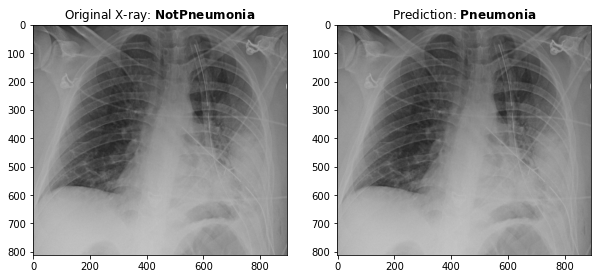

In [49]:
pathology="Pneumonia"
df_index=4903
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
show_xray(rsna_test_df.loc[df_index]['xray_file'])
plt.title("Original X-ray: "+ r"$\bf{Not Pneumonia"+ "}$");
plt.subplot(1,2,2)
show_xray(rsna_test_df.loc[df_index]['xray_file'])
plt.title("Prediction: "+ r"$\bf{Pneumonia"+ "}$");